# Linear Regression

Regression is used to predict outputs that are *continuous*

*******************************************************************************************************************************
#### Aside: Distance Formula
   For two sets of points $[a_1,a_2]$ and $[b_1,b_2]$ 
* **Euclidean Distance**
    $d = \sqrt{(a_1 - b_1)^2 + (a_2 - b_2)^2}$
* **Manhattan Distance**
    $d = |a_1 - b_1| + |a_2 - b_2|$
* **Hamming Distance**
    Hamming distance tells us how many points are equal, for example: the two strings 'there' and typo 'thete' would have a Hamming distance of 1. We can do this for lists too. Note: both objects must have the same dimensions.
    
There are specific functions in SciPy for calculating these too: distance.euclidean(), distance.cityblock(), distance.hamming()
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html
*******************************************************************************************************************************

When we plot a linear regression, each data point has a loss from the *true* value, which measures how bad the model's prediction was. The loss is the *squared distance* from the point to the line. We want to *minimise* the losses, see **Least Squares as Maximum Likelihood Estimator** in **Notes on Statistics & Modelling** (that's essentially whats going on).

To test out using **Linear Regression** I'm going to create a random set of $x$ values and sort it for our linear fit. To generate our 'fake' data we fit $y = mx + b$ and then 'randomise' it by adding *normally distributed noise*. The notation for this is:
$$ D \sim \mathcal{N} \left(M(\theta), \sigma_{obi}^2 \right) $$
$$ M(\theta) = \alpha (mx + b) $$

where $M(\theta)$ is our model, which in this case is *linear*, $\alpha$ represents the **activation**(?).

https://emcee.readthedocs.io/en/stable/tutorials/line/

# Creating Noisy Data

Below I have plotted a variety of different 'randomised linear data'. 

* The first plot contains data which is normally distributed with $\sigma = y_{err}$. This shows data points which are very well aligned to the true value, however it's not realistic to noisy data.

* The second plot is is much more scattered because we are setting $\sigma = y_{err}* f_{true}$. The bigger our value for $f_{true}$, the larger our spread. This does a better job of simulating real data which has a weak(er) linear correlation.

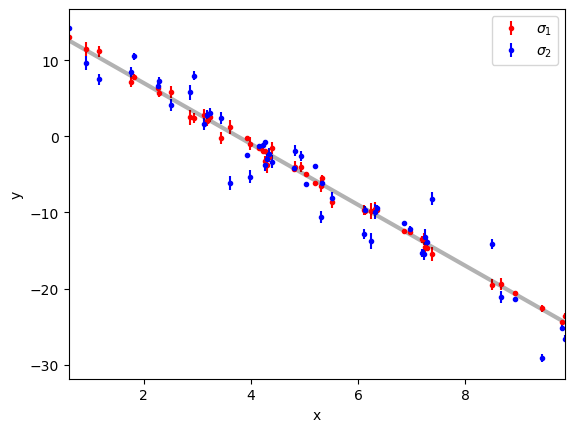

In [1]:
import numpy as np
import matplotlib.pyplot as plt

'''
Creating fake linear regression data, with the true
fit denoted by the thick grey line
'''

np.random.seed(123) # --> same set of random numbers appear every time.

# Choose the "true" parameters --> thick grey line in graph.
m_true = -4 
b_true = 15
f_true = 5 # --> determines how spread our fake data is

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N)) # --> gives ordered N random variables between 0 and 10
yerr = 0.1 + 1 * np.random.rand(N) # --> random error values for data
y_true = m_true * x + b_true # --> the value which our data will be spread about

y1 = np.random.normal(loc=y_true, scale=yerr, size=N) 
y2 = np.random.normal(loc=y_true, scale=yerr*f_true, size=N) 

plt.errorbar(x, y1, yerr=yerr, fmt=".r", capsize=0, label='$\sigma_1$')
plt.errorbar(x, y2, yerr=yerr, fmt=".b", capsize=0, label = '$\sigma_2$')
plt.plot(x, y_true, "k", alpha=0.3, lw=3)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

y = y2 # --> set which y we are going to use

## Linear Least Squares

Now we want to find the Least Squares best-fit model to this data. From the **Statistics Notes** we know that all we need to do to find the parameters $m$ and $b$ is solve the equation:
$$ m = \frac{N \sum xy - \sum x \sum y}{N \sum (x^2) - \sum (x)^2} $$
and
$$ b = \frac{ \sum y - m \sum x}{N} $$

True parameters:
m = -4.000 b = 15.000 f = 5.000

Simple Least-Squares estimates:
m = -4.127 b = 15.434 f = 5.570


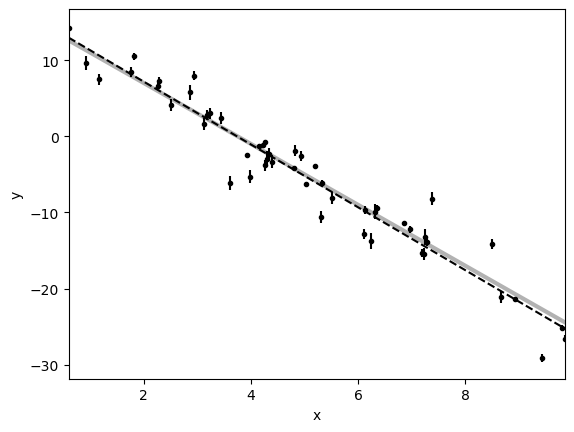

In [2]:
def simple_least_squares(x,y):
    N = len(x)
    sum_xy = np.sum(x*y)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    
    m = (N * sum_xy - sum_x * sum_y)/(N * sum_x2 - (sum_x)**2)
    b = (sum_y - m * sum_x)/N
    
    y_ls = m*x + b
    sigma2 = np.sum((y_ls-y)**2)/(N-1)
    f = np.sqrt(sigma2)/yerr
    SE = np.sqrt(sigma2/N)

    return y_ls, m, b, f, SE 

w = simple_least_squares(x,y2)

print("True parameters:")
print("m = {0:.3f}".format(m_true), "b = {0:.3f}".format(b_true),"f = {0:.3f}".format(f_true))
print()
print("Simple Least-Squares estimates:")
print("m = {0:.3f}".format(w[1]),"b = {0:.3f}".format(w[2]),'f = {0:.3f}'.format(np.mean(w[3])))
# Is there a better way of finding f?

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3)
plt.plot(x, w[0], 'k--')
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now that I have created a simple 1-dimensional least-squares fitting function, I will do the same thing but in **matrix** forumlation. This procedure calculates argmax(L):

$$ Y = \begin{bmatrix}
        y_1\\
        y_2\\
        \vdots\\
        y_N
        \end{bmatrix}$$

$$ A = \begin{bmatrix}
        1 & x_1\\
        1 & x_2\\
        \vdots & \vdots\\
        1 & x_N
        \end{bmatrix}$$

$$ C = \begin{bmatrix}
        \sigma_{y1}^2 & 0 & \dots & 0\\
        0 & \sigma_{y2}^2 & \dots & 0\\
        \vdots & \vdots & \ddots & \vdots\\
        0 & 0 & \dots & \sigma_{yN}^2
        \end{bmatrix}$$

$$\begin{bmatrix}
 m\\
 b
\end{bmatrix}  = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y]$$

Least-squares estimates:
m = -4.190 ± 0.024
b = 16.149 ± 0.135
[-4.18952018 16.14884586]


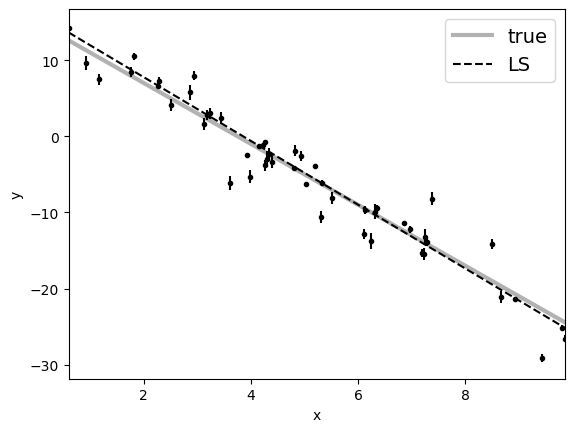

In [3]:
A = np.vander(x, 2) # --> design matrix
Y = np.array(y)
C = np.linalg.inv(np.diag(yerr * yerr)) # --> Inverse of the Covariance Matrix
ATCA = np.dot(np.dot(A.T,C),A)
cov = np.linalg.inv(ATCA) # --> uncertainty
ATCY = np.dot(np.dot(A.T, C),Y)
B = np.dot(np.linalg.inv(ATCA),ATCY)
y_ls = x*B[0] + B[1]

print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(B[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(B[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label="true")
plt.plot(x, y_ls, "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

print(B)

https://www.stat.purdue.edu/~boli/stat512/lectures/topic3.pdf

https://arxiv.org/pdf/1008.4686.pdf

## Generative Model
### 1. Gradient Descent

https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent

https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931


One process of minimizing the loss is called **Gradient Descent**. It is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. It's a generative model, and works by minimising the ***Loss Function***, given by:

$$ \frac{1}{N} \sum_{i=0}^N \left(y_i - (m x_i + b) \right)^2 $$

where *N* is the number of points in our data set, *m* is our current gradient guess, and *b* is our current intercept guess. Note: there is an analytical solution to this problem, but for the purposes of this project I will create an algorithm to calculate it for me.

To minimise we need to make the partial derivatives as small as possible. The partial derivative wrt *b* is:

$$ -\frac{2}{N} \sum_{i=0}^N \left(y_i - (m x_i + b) \right) $$

In order to make *b* converge on the optimal values, we first need to calculate what the gradient of *b* currently is.

In [4]:
def get_gradient_at_b(x, y, b, m):
    ''' 
    Finds the partial derivative of the 
    loss function wrt b at that point and 
    returns b_gradient
    '''    
    N = len(x)
    diff = 0
    for i in range(N):
        x_val = x[i]
        y_val = y[i]
        diff += (y_val - ((m * x_val) + b))
    b_gradient = -(2/N) * diff  
    return b_gradient

Similarly, to find the gradient at *m* we take the partial derivative of the loss function wrt *m* to obtain:

$$ -\frac{2}{N} \sum_{i=0}^N x_i\left(y_i - (m x_i + b) \right) $$

In [5]:
def get_gradient_at_m(x, y, b, m):
    ''' 
    Finds the partial derivative of the 
    loss function wrt m at that point and 
    returns m_gradient
    '''
    N = len(x)
    diff = 0
    for i in range(N):
        x_val = x[i]
        y_val = y[i]
        diff += x_val * (y_val - ((m * x_val) + b))
    m_gradient = -(2/N) * diff  
    return m_gradient

Now the plan is to iterate down the gradient to find the values of *b* and *m* such that they are minimised, but we don't want to move them so much that we overstep the minimum point. We can set the scale of the movement, which is called the **learning rate**. A learning rate too big might never converge, and a rate too small might take too long! First we create a function which moves one-step closer to our optimal values. Then we create a function which iterates through *num_iterations* times, until we get our desired output.

In [6]:
def step_gradient(b_current, m_current, x, y, learning_rate):
    '''
    Takes current variables and returns values for
    b and m which are 1 step closer to the optimal
    values
    '''
    
    # current (b,m) gradient, which we need to move closer to the minimum.
    b_gradient = get_gradient_at_b(x, y, b_current, m_current)
    m_gradient = get_gradient_at_m(x, y, b_current, m_current)
    
    # moving the values closer to minimum
    b = b_current - (learning_rate * b_gradient)
    m = m_current - (learning_rate * m_gradient)
    return [b, m]

'''*********************************************************************'''

def gradient_descent(x,y,learning_rate,num_iterations):
    ''' 
    Uses step_gradient() many times to converge on the
    optimal parameters
    '''
    # initial guess
    b = 0
    m = 0
    for i in range(num_iterations):
        b, m = step_gradient(b, m, x, y, learning_rate)
    return [b,m]

Now, using this function with the data we had before:

15.434349030770955 -4.127243515182114
15 -4


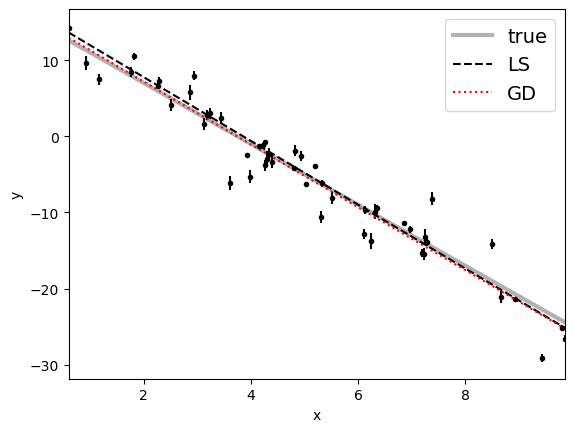

In [7]:
''' Including our Gradient Descent '''
b_gd, m_gd = gradient_descent(x, y, 0.01, 10000)
y_gd = (m_gd * x) + b_gd

print(b_gd, m_gd)
print(b_true, m_true)

''' Plotting '''
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label='true')
plt.plot(x, y_ls, "--k", label="LS")
plt.plot(x, y_gd, 'r:', label='GD')
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

With enough iterations the **Gradient Descent** model should converge with the **Least Squares** fit. The GD model *looks* to fit better, but because of how spread the data is, there's really no point deliberating which model is 'slightly better'.

## Maximum Likelihood Estimation

A different MLE technique. We want to find the log of the likelihood and *minimise* it to find the correct model to use.

$$ \ln{ p(y|x,\sigma,m,b,f)} = - \frac{1}{2} \sum_n \left[\frac{(y_n - m x_n - b)^2}{s_n^2} + \ln(2 \pi s_n^2) \right] $$

$$ s_n = f \sigma_n $$

In [8]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = (np.exp(log_f)*yerr)**2 # --> f can't be negative
    return -0.5 * np.sum((y - model)** 2 / sigma2 + np.log(2*np.pi*sigma2))

From here we use the *scipy.optimize* module to find the best fit of this function

True parameters:
m = -4.000 b = 15.000 f = 5.000

Least-squares estimates:
m = -4.190 ± 0.024 b = 16.149 ± 0.135

Gradient Descent estimates:
m = -4.127 b = 15.434

Maximum likelihood estimates:
m = -4.190 b = 16.149 f = 4.276



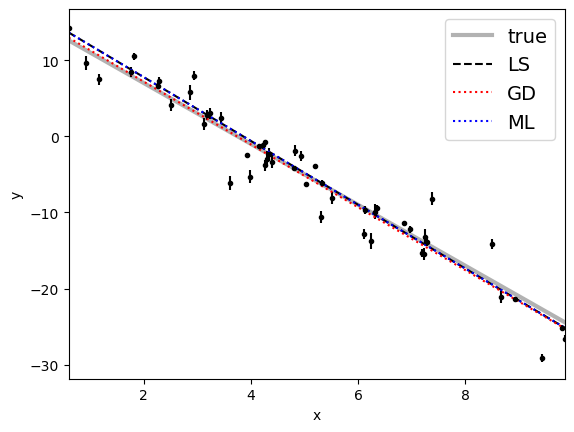

In [9]:
from scipy.optimize import minimize
np.random.seed(42) # For some reason this only works with this particular seed

nll = lambda *args: -log_likelihood(*args) 
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("True parameters:")
print("m = {0:.3f}".format(m_true), "b = {0:.3f}".format(b_true),"f = {0:.3f}".format(f_true))
print()
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(B[0], np.sqrt(cov[0, 0])),
      "b = {0:.3f} ± {1:.3f}".format(B[1], np.sqrt(cov[1, 1])))
print()
print("Gradient Descent estimates:")
print("m = {0:.3f}".format(m_gd), "b = {0:.3f}".format(b_gd))
print()
print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml), "b = {0:.3f}".format(b_ml),"f = {0:.3f}".format(np.exp(log_f_ml)))
print()

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, y_true, "k", alpha=0.3, lw=3, label="true")
plt.plot(x, y_ls, "--k", label="LS")
plt.plot(x, y_gd, 'r:', label='GD')
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":b", label="ML")
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y");

# Scikit-Learn

[-4.12724352]


Text(0, 0.5, 'y')

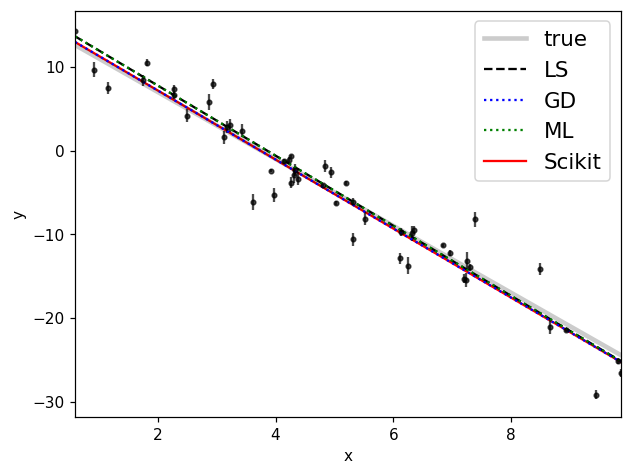

In [10]:
from sklearn.linear_model import LinearRegression

line_fitter = LinearRegression()
line_fitter.fit(x.reshape(-1,1), y)
skl_predict = line_fitter.predict(x.reshape(-1,1))
print(line_fitter.coef_)

#                  NOTE
# We need to reshape x for scikit to work

figure = plt.figure(dpi=110)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.7)
plt.plot(x, y_true, "k", alpha=0.2, lw=3, label="true")
plt.plot(x, y_ls, "--k", label="LS")
plt.plot(x, y_gd, 'b:', label='GD')
plt.plot(x, np.dot(np.vander(x, 2), [m_ml, b_ml]), ":g", label="ML")
plt.plot(x, skl_predict, 'r', label='Scikit', zorder=1)
plt.legend(fontsize=14)
plt.xlim(min(x), max(x))
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig('Lin_reg_test.png')

## Marginalization & uncertainty estimation

We want to find an estimate of the *posterior probability function*. **MCMC** (Markov chain Monte Carlo) creates samples from a continuous random variably, with a probability density $\propto$ a known function. These samples can be used to evaluate an integral over that variable, as its expected value or variance. https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

The ***posterior probability function*** $$ p(m,b,f | x,y,\sigma) \propto p(m,b,f) p(y|x,\sigma,m,b,f) $$

where $p(y|x,\sigma,m,b,f)$ is the *liklihood*, and $p(m,b,f)$ is the *prior*. We must write down priors if using MCMC, and we cannot draw parameter samples from the liklihood function.

In this instance the priors are: 
$$ p(m) = \begin{cases}
    1/5.5, & \text{if -6 < m < 1/2}\\
    0, & \text{otherwise}
  \end{cases}$$

In [11]:
def log_prior(theta):
    m, b, log_f = theta
    if -6.0 < m < 10.5 and 5.0 < b < 35.0 and -5.0 < log_f < 2.0:
        return 0.0
    return -np.inf

In [12]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

https://emcee.readthedocs.io/en/stable/user/sampler/

In [13]:
import emcee

pos = soln.x + 0.75 * np.random.randn(32, 3) # using the MLE model
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 10000, progress=True);

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/Users/guneraygin/miniconda3/envs/pymc3_env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1402.53it/s]


In [14]:
soln.x

array([-4.18952017, 16.14884586,  1.45290792])

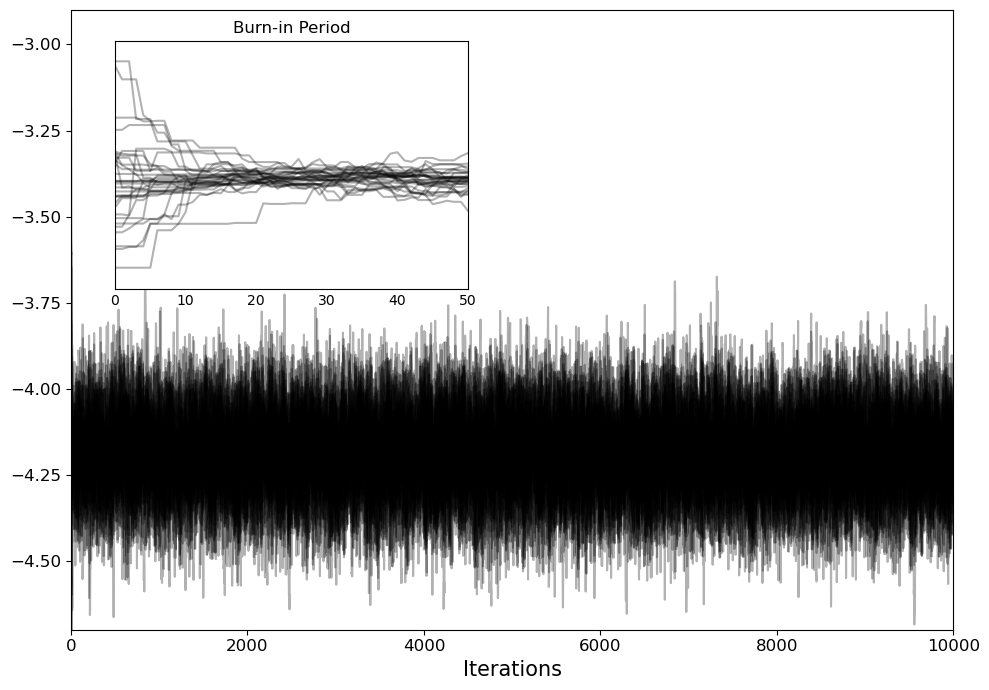

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the trace of the first parameter
ax.plot(sampler.get_chain()[:, :, 0], 'k', alpha=0.3)
ax.set_xlim(0, 10000)
ax.set_ylim(-4.7, -2.9)
ax.set_xlabel('Iterations', size=15)
ax.tick_params(axis='both', labelsize=12)

# Add a zoom-in of the burn-in period
ax_zoom = ax.inset_axes([0.05, 0.55, 0.4, 0.4])
ax_zoom.plot(sampler.get_chain()[:100, :, 0], 'k', alpha=0.3)
#ax_zoom.set_xticklabels([])
ax_zoom.set_yticklabels([])
ax_zoom.tick_params(axis='both', length=0, width=0)
ax_zoom.set_xlim(0,50)
ax_zoom.set_ylim(-5.3, -2.8)
ax_zoom.set_title('Burn-in Period', size=12)
# Adjust the layout of the subplots
fig.tight_layout()

#plt.savefig('MCMC plot.png')
plt.show()

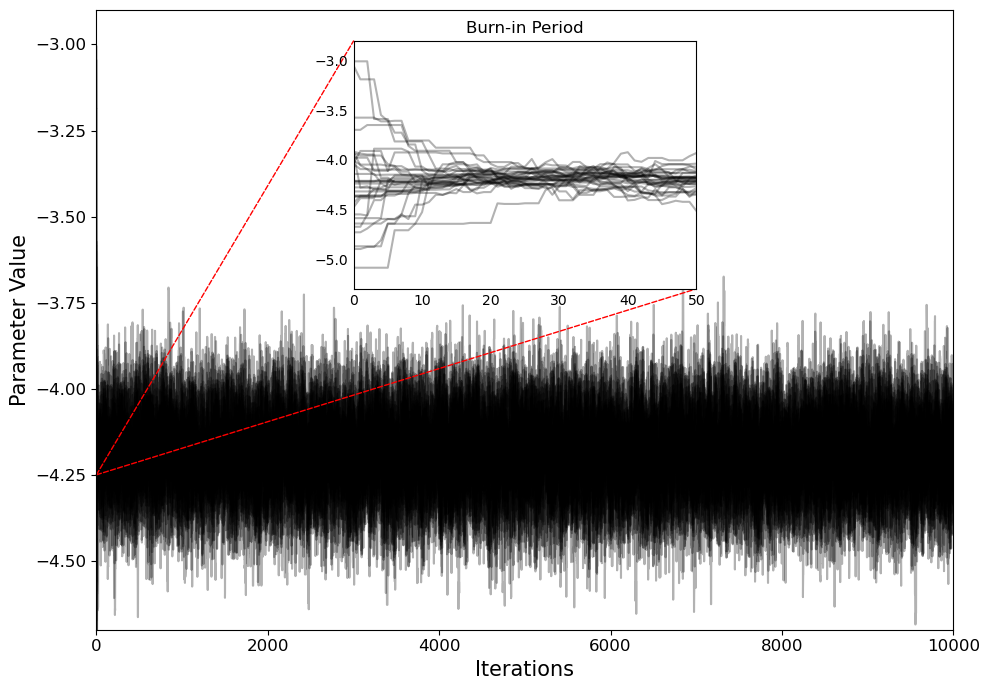

In [16]:
from matplotlib.patches import ConnectionPatch

fig, ax = plt.subplots(figsize=(10, 7))

# Plot the trace of the first parameter
ax.plot(sampler.get_chain()[:, :, 0], 'k', alpha=0.3, zorder=1)
ax.set_xlim(0, 10000)
ax.set_ylim(-4.7, -2.9)
ax.set_xlabel('Iterations', size=15)
ax.set_ylabel('Parameter Value', size=15)
ax.tick_params(axis='both', labelsize=12)

# Add a zoom-in of the burn-in period
ax_zoom = ax.inset_axes([0.3, 0.55, 0.4, 0.4])
ax_zoom.plot(sampler.get_chain()[:100, :, 0], 'k', alpha=0.3)
#ax_zoom.set_yticklabels([])
ax_zoom.tick_params(axis='both', length=0, width=0)
ax_zoom.set_xlim(0,50)
ax_zoom.set_ylim(-5.3, -2.8)
ax_zoom.set_title('Burn-in Period', size=12)

# Add ConnectionPatches to connect the two subplots
con1 = ConnectionPatch(xyA=(0, -4.25), coordsA=ax.transData, 
                       xyB=(50, -5.3), coordsB=ax_zoom.transData, 
                       color='red', linestyle='--', linewidth=1)
ax.add_artist(con1)

con2 = ConnectionPatch(xyA=(0, -4.25), coordsA=ax.transData, 
                       xyB=(0, -2.8), coordsB=ax_zoom.transData, 
                       color='red', linestyle='--', linewidth=1)
ax.add_artist(con2)

fig.tight_layout()
#plt.savefig('../Figures/MCMC plot.png')
plt.show()

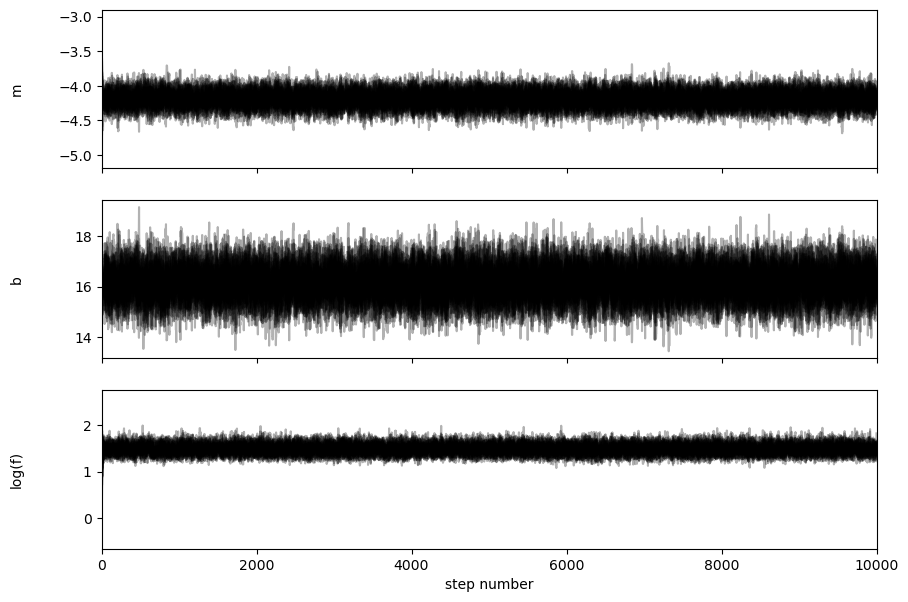

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

The walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. After fewer than 50 steps, the samples seem pretty well “burnt-in”.

In [18]:
tau = sampler.get_autocorr_time()
print(tau)

# Tells us roughly how many steps are needed for the chain to forget where it started

[38.51047875 39.52984303 39.0759785 ]


In [19]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(20256, 3)


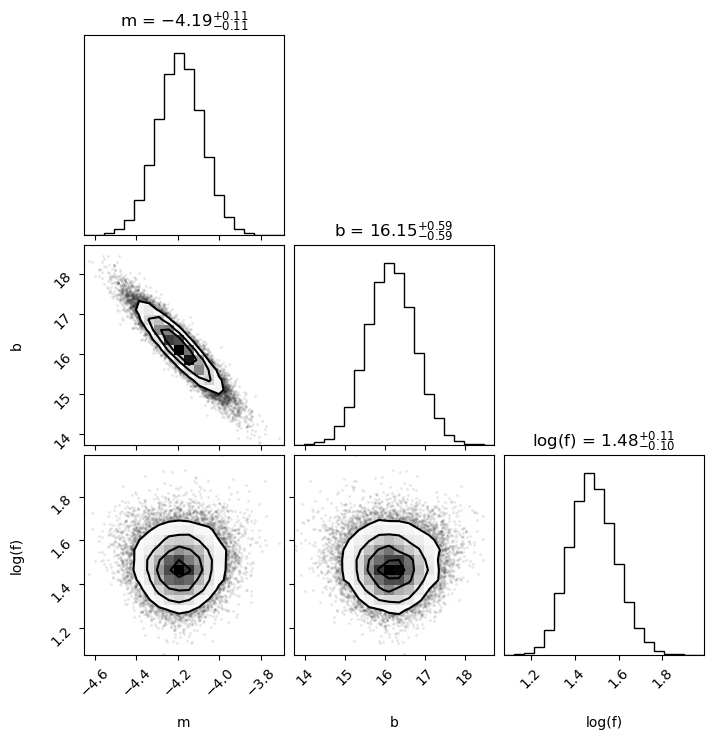

In [20]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)],
    show_titles=True
);

The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters.

Below we are plotting N random samples from our random walks (100 here) to show how they compare with the true value.

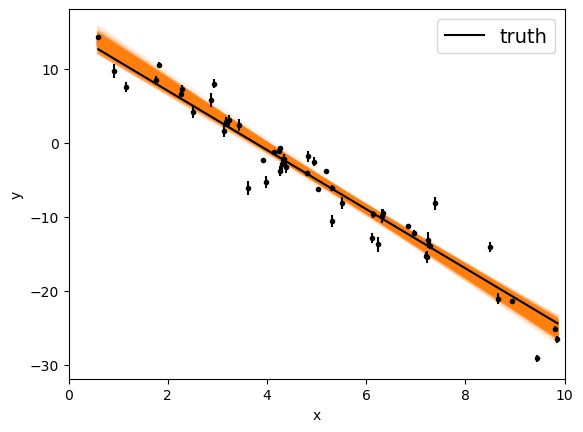

In [21]:
inds = np.random.randint(len(flat_samples), size=1000) # which random walk we will be choosing
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, m_true * x + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");